In [31]:
push!(LOAD_PATH, ".")
using FFTWtoolkit, FFTW
using LinearAlgebra
using HDF5, DelimitedFiles
using PyPlot

In [3]:
arxname="../JLDFiles/Desinhibida/180116s1cut_evento_5.h5"

"../JLDFiles/Desinhibida/180116s1cut_evento_5.h5"

In [4]:
arx=h5open(arxname)

HDF5 data file: ../JLDFiles/Desinhibida/180116s1cut_evento_5.h5

In [5]:
names(arx)

7-element Array{String,1}:
 "CanalesSaturados"
 "Canalesrespuesta"
 "KTT_KInv"        
 "LFPTotal"        
 "Nota"            
 "freq"            
 "kCSDCorrecta"    

Todos los tiempos estan en cuadros, esto es, en 1/freq de segundo. Para las transformadas de Fourier (o graficas bonitas) tenemos que multiplicar los rangos por los factores adecuados.

In [6]:
lfp=read(arx, "LFPTotal")
saturados=read(arx, "CanalesSaturados")
buenos=read(arx, "Canalesrespuesta")
freq=read(arx, "freq")
#late=read(arx, "latencia")
#fin=read(arx,"final")
#retrazo=read(arx,"retrazo")
#println(freq, " ", late, " ", fin , " ", retrazo )

7.022058198545425

In [7]:
nmax=size(lfp)[3]

2001

In [8]:
iniact=retrazo+late # Retrazo + latencia = inicio de señal

UndefVarError: UndefVarError: retrazo not defined

In [9]:
#rango=iniact:fin
#mejor contamos desde cero, no? el momento cero es el inicial (aunque el indice no)!!!
rango=1:nmax

1:2001

In [10]:
buenos

798×2 Array{Int64,2}:
 38   5
 53  36
 57  23
 56  30
 32  19
  6  21
 38   6
 45   8
 48  34
 54  28
 42  42
 40  27
 44  29
  ⋮    
 42  22
 55  17
 51  30
 44  26
 24  20
 35  10
 41  26
 29   5
 59  28
 37  18
 44  28
 43  28

In [14]:
saturados #terrible wring

1×2 Array{Int64,2}:
 1  1

In [15]:
ejemplolfp=lfp[43,38,:];

In [16]:
tmax=nmax/freq
rangotiempos=(rango.-1)./freq
rangofreqs=(rango.-1)./tmax
rfreqsim=map(x->-freq/2+(x-1)*freq/(nmax-1),rango);
rfreqsim[1001]

0.0

In [17]:
rfreqsim[1000]

-0.003511029099272811

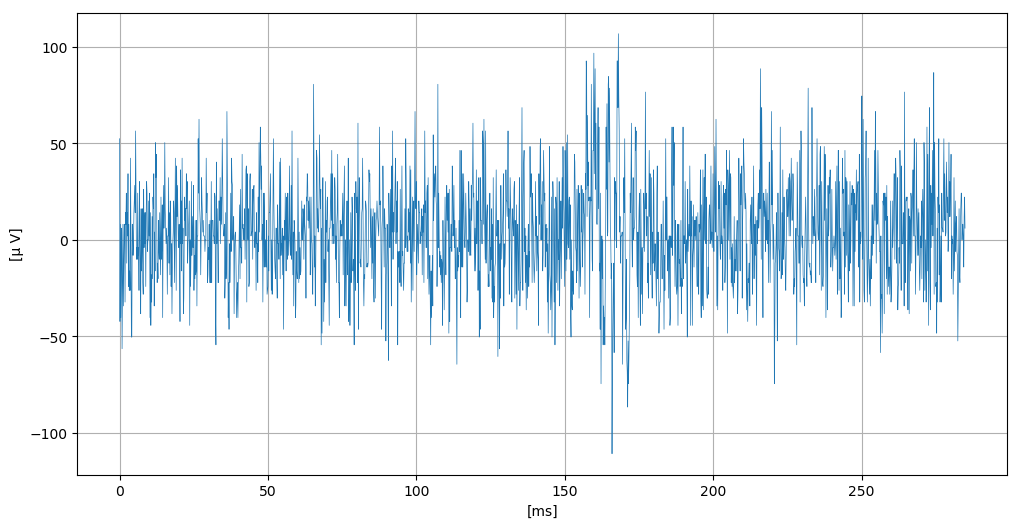

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f49167e0eb8>

In [18]:
figura=figure(figsize=(12,6))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
plot(rangotiempos, ejemplolfp, lw=0.5)

In [19]:
plan=plan_fft(ejemplolfp,  flags=FFTW.PATIENT)
fttotal=(plan*ejemplolfp);
ftsym=circshift(fttotal, div(nmax,2));

In [20]:
div(102,2)

51

In [21]:
epoder=map(abs2, ftsym);

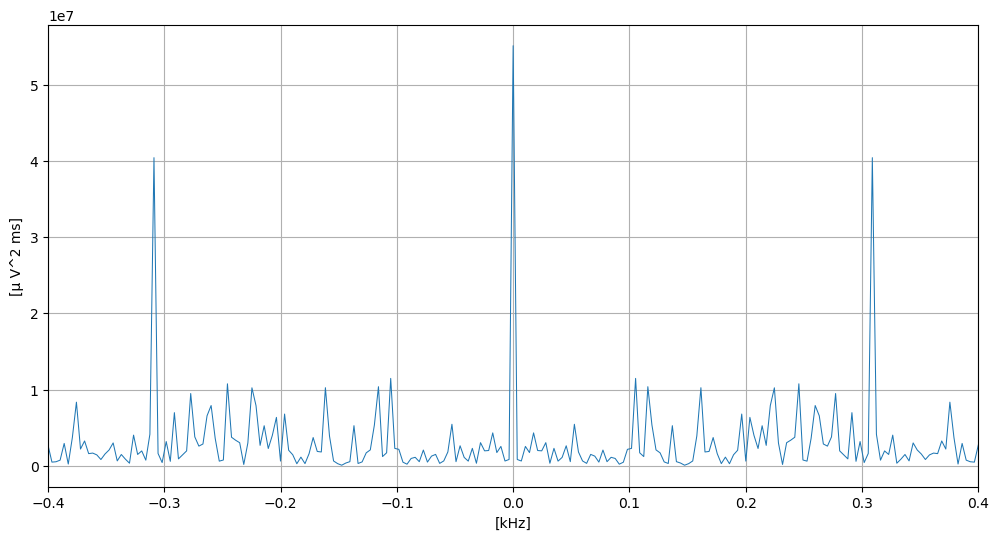

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4920492908>

In [22]:
figura=figure(figsize=(12,6))
grid(which="both")
xlim(-0.4,0.4)
xlabel("[kHz]")
ylabel("[μ V^2 ms]")
#yscale("log")
mediorango=1:500
plot(rfreqsim,epoder, lw=0.74)
#plot(rangofreqs[mediorango],epoder2[mediorango])

In [23]:
rangofreqs.step

Base.TwicePrecision{Float64}(0.003509274462041692, 0.0)

In [24]:
rara2=filtrobanda(rangofreqs, fttotal, 0.001,0.05);

In [25]:
fttotal[2:14]

13-element Array{Complex{Float64},1}:
  238.60655832460384 + 873.5683087259881im 
  351.10162779264715 + 704.7461932530772im 
 -1439.5403771806496 + 679.7191801886249im 
   145.8022332455397 - 1306.391211759748im 
   396.2878358199724 + 2038.5014193005372im
 -1157.5278468967829 - 810.208006197357im  
   1222.770273886743 + 677.1125107685262im 
 -1103.5379009774153 + 1346.743384882443im 
    519.013228396948 + 236.05371898954485im
 -1381.3614839982492 + 610.7120282983146im 
  -606.2565949387641 + 485.70486283397133im
  -35.30149518986116 + 1045.152429466533im 
 -240.10486977173423 - 1599.763395891378im 

In [26]:
fttotal[1989:2001]

13-element Array{Complex{Float64},1}:
  -240.1048697717339 + 1599.7633958913777im
 -35.301495189861384 - 1045.1524294665328im
  -606.2565949387645 - 485.7048628339712im 
 -1381.3614839982488 - 610.7120282983149im 
   519.0132283969481 - 236.05371898954488im
 -1103.5379009774153 - 1346.7433848824426im
  1222.7702738867433 - 677.1125107685262im 
 -1157.5278468967822 + 810.2080061973572im 
    396.287835819972 - 2038.5014193005368im
  145.80223324553975 + 1306.391211759748im 
 -1439.5403771806496 - 679.7191801886252im 
   351.1016277926468 - 704.7461932530773im 
   238.6065583246037 - 873.5683087259879im 

Muy bien, hasta ahí parece funcionar. Hay que checar que esto también jale con indices pares. Ahora aplicamos a esto a los datos completos.

In [27]:
ffTotalTotal=zeros(Complex, 64, 64, nmax);
for j=1:64, k=1:64
    ffTotalTotal[j,k,:]=plan*vec(lfp[j,k,:])
end

In [28]:
# = funciones auxiliares para bandas "ineteresantes =#
fbajas(datos)=filtrobanda(rangofreqs,datos, 0.010, 0.060)
fmedias(datos)=filtrobanda(rangofreqs, datos, 0.1, 0.2)
faltas(datos)=filtrobanda(rangofreqs, datos, 0.2, 0.3)
faltotas(datos)=filtrobanda(rangofreqs, datos, 0.3, 0.45)

faltotas (generic function with 1 method)

Las unidades son un relajo. Tenemos que $V^2 \cdot s$ ( Volts cuadrados por segundos ) son Joules entre Coulombs. La transformada de Fourier esta en $ V \cdot s$, Volts segundos. Al cuadrar y multiplicar por $ d \omega$,nos da otra vez $ V^2 s$ que esta bien. Pero nuestra señal esta en $mV \cdot ms$. Eso da que la Transformada de Fourier está en $10^{-6} Vs$. Al cuadrar queda en $10^{-12}$, y nuestra $d \omega$ esta en kHz. Por ende el resultado de la integral esta en $10^{-9} J/C$.

In [32]:
factor=10^9
poderbajo=zeros(Real, 64,64)
podermedio=zeros(Real, 64,64)
poderalto=zeros(Real, 64,64)
poderaltote=zeros(Real, 64,64)
for j=1:64, k=1:64
    aux=fbajas(ffTotalTotal[j,k,:])
    poderbajo[j,k]=convert(Real, dot(aux,aux))/factor
    aux=fmedias(ffTotalTotal[j,k,:])
    podermedio[j,k]=convert(Real, dot(aux,aux))/factor
    aux=faltas(ffTotalTotal[j,k,:])
    poderalto[j,k]=convert(Real, dot(aux,aux))/factor
    aux=faltotas(ffTotalTotal[j,k,:])
    poderaltote[j,k]=convert(Real, dot(aux,aux))/factor
end

In [33]:
extrema(poderalto)

(0.016332603857332668, 84.68886466276146)

In [34]:
saturados

1×2 Array{Int64,2}:
 1  1

In [35]:
satux=saturados[:,2]
satuy=saturados[:,1]
bonsx=buenos[:,2]
bonsy=buenos[:,1];

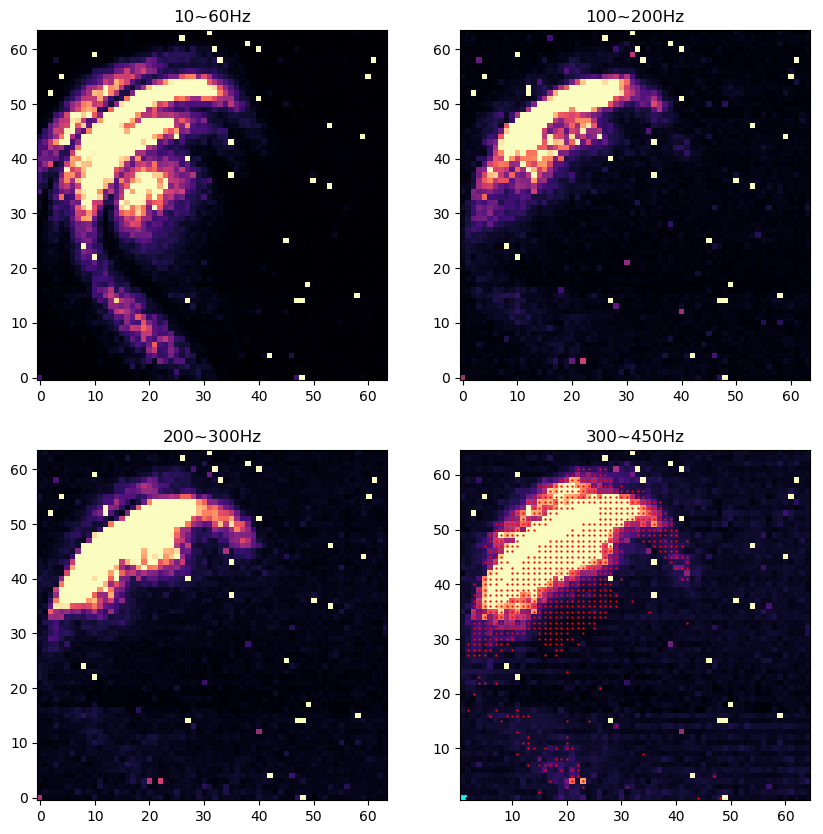

In [36]:
farofa, lista =subplots(2,2, figsize=(10,10))

(pmin, pmax)= (0, 2)

exten=[0.5,64.5,0.5,64.5]

lista[1,1][:imshow](poderbajo, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,1][:title][:set_text]("10~60Hz")

lista[1,2][:imshow](podermedio, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[1,2][:title][:set_text]("100~200Hz")

lista[2,1][:imshow](poderalto, vmin=pmin, vmax=pmax, origin="lower", cmap="magma")
lista[2,1][:title][:set_text]("200~300Hz")

lista[2,2][:imshow](poderaltote, vmin=pmin, vmax=pmax, origin="lower", cmap="magma", extent=exten)
lista[2,2][:title][:set_text]("300~450Hz")

scatter(bonsx, bonsy, marker="o", c="red", s=0.4)
scatter(satux, satuy, marker="x", c="cyan", s=20)


#farofa[:colorbar](lista[2,2], ax=lista, orientation="horizontal", fraction=.1)

savefig("EspectrosdePoderporBandas.png", dpi=90)

#colorbar()

In [37]:
skt=wfft(ejemplolfp, 350);
ranguitof=(0:349).*(freq/350)

0.0:0.0200630234244155:7.001995175121009

In [38]:
epoder=map(abs2, skt)./factor;

In [49]:
extrema(epoder), size(epoder)

((0.0, 0.0057011601216394574), (1651, 350))

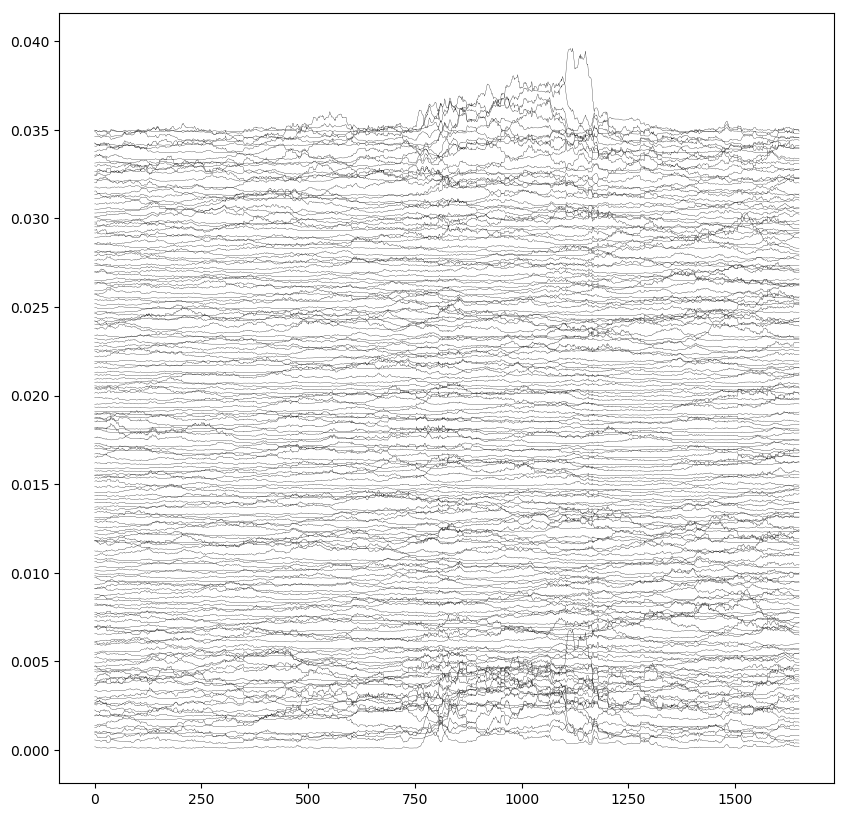

In [48]:
f=figure(figsize=(10,10))
#xlim(0,2)
#axis("off")

for j=1:2:(350)
    datos=vec(epoder[:,j+1]).+(j*0.0001)
    plot(datos, lw=0.2, c="black")
end

#savefig("texturadefrequenciasa01.png", dpi=90)


In [ ]:
a,b=size(epoder)
xx=collect(1:a)
yy=collect(1:b);

xxs=repeat(xx,outer=(1,b))
yys=permutedims(repeat(yy, outer=(1,a)))

xxs=xxs./freq
yys=yys.*(freq/350)

#plot_wireframe(xxs, yys, epoder)

In [ ]:
xxs

In [ ]:
f=figure(figsize=(15,15))
ylim(0,3.5)
xlabel("Tiempo ms")
ylabel("frequencia kHz")
zlabel("Poder J/C")
plot_surface(xxs[:,1:170], yys[:,1:170], epoder[:,1:170], lw=0.5)

In [ ]:
?view

In [ ]:
figura=figure(figsize=(13,10))
grid()
#xlim(120,170)
xlabel("[ms]")
ylabel("[μ V]")
#plot(rangotiempos, signalfiltrad, lw=1.5)
plot(rangotiempos, signalfiltrad2, lw=1.5)
#plot(rangotiempos, signalfiltrad+signalfiltrad2, lw=1.65)
plot(rangotiempos, ejemplolfp, lw=0.3)


In [ ]:
a=0.053022
tol=2*step(rangofreqs)
q(x)=isapprox(a,x, atol=tol)
findfirst(q, rangofreqs)


In [ ]:
rangofreqs[12:17]

In [ ]:
map(q, rangofreqs[12:17])

In [ ]:
collect(rangofreqs[12:17])

In [ ]:
step(rangofreqs)

In [ ]:
a=0.005
p=indicecercano(a, rangofreqs)

In [ ]:
rangofreqs[2]

In [ ]:
rangofreqs[57]

In [ ]:
figura=figure(figsize=(12,6))
grid()
xlabel("[kHz]")
ylabel("[μ V^2]")
plot(subfreqs,epoder2)